<h1 style='color: brown; text-align:center;'>
    Обучение нейронной сети для распознавания рукописных цифр на изображениях из базы MNIST
</h1>

<h5 style='color: green; text-align:center;'>
    Импорт основных модулей
</h5>
<ul>
    <li>
        Импортируется стандартный класс <b>numpy</b> для работы с векторами и матрицами
    </li>
    <li>
        Импортируется стандартный класс <b>time</b> для замера времени работы скриптов
    </li>
    <li>
        Выставляется путь к папке с кодом
    </li>
    <li>
        Импортируется класс <b>Img</b> для хранения и обработки изображения
    </li>
    <li>
        Импортируется класс <b>Imgs</b> для хранения массива всех изображений
    </li>
    <li>
        Импортируется класс <b>LayerFC</b>, представляющий один полносвязный слой нейронной сети
    </li>
    <li>
        Импортируется класс <b>NeuralNetwork</b>, представляющий нейронную сеть и функцию <b>nn_load</b> для загрузки параметров сохраненной на диске сети
    </li>
</ul>

In [1]:
import numpy as np
import time
import sys
sys.path.append('./../')

from cap_solver.image.img import Img
from cap_solver.image.imgs import Imgs
from cap_solver.neural_network.layer_fc import LayerFC
from cap_solver.neural_network.neural_network import NeuralNetwork, nn_load

<h5 style='color: green; text-align:center;'>
    Функция, переводящая символ ($0, 1, \ldots, 9$) на изображении в вектор длины $10$
</h5>

In [3]:
def fsmb2vec(s):
    ''' Symbol may contain 0-9 numbers. '''
    v = np.zeros((10, 1))
    v[int(s)] = 1.
    return v

<h5 style='color: green; text-align:center;'>
    Загрузка изображений
</h5>
<ul>
    <li>
        Инициализация класса, хранящего изображения и выставление опции печати промежуточной информации
    </li>
    <li>
        Распаковка изображений из архива (база mnist из 70000 распознанных рукописных цифр)
    </li>
    <li>
        Отрисовка шести первых изображений для примера
    </li>
</ul>

Total time   (sec.):    3.9
Time per img (sec.):    0.0001
Total number of img:     70000


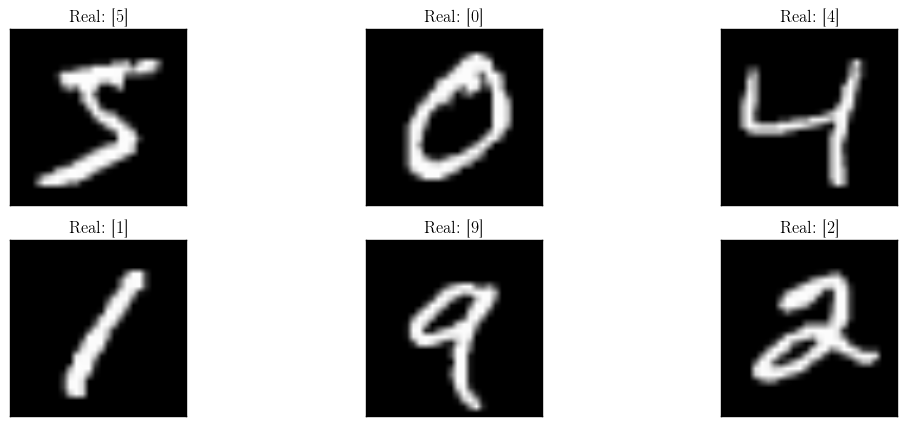

In [4]:
Ims = Imgs(fsmb2vec=fsmb2vec, verb=True)
Ims.load('./data/mnist/mnist.pkl.gz', dtype='mnist')
Ims.show(n=6, c=3, figsize=(13, 5), figsize_sub=(4, 4))

<h5 style='color: green; text-align:center;'>
    Анализ изображений (на примере первого изображения в базе)
</h5>
<ul>
    <li>
        Вычисление и отображение (в виде списка из пар: номер цвета - количество пикселей) гистограммы цветов (функция calc_hist)
    </li>
    <li>
        Явное отображение (в виде красных кругов) первых двух по распространенности на изображении цветов (функция show_colors)
    </li>
</ul>

C:  0->   618      | C:253->    54      | C: 18->     5      | C:  2->     3      | C: 11->     3      |
C:154->     3      | C:  1->     2      | C:136->     2      | C: 16->     2      | C: 39->     2      |
C:172->     2      | C:182->     2      | C:190->     2      | C: 64->     2      | C:195->     2      |
C:198->     2      | C: 80->     2      | C: 81->     2      | C: 82->     2      | C:219->     2      |
C: 93->     2      | C:225->     2      | C:241->     2      | C:247->     2      | C:249->     2      |
C:  3->     1      | C:132->     1      | C:133->     1      | C:135->     1      | C:  9->     1      |
C:130->     1      | C: 14->     1      | C:148->     1      | C:171->     1      | C:150->     1      |
C: 23->     1      | C: 24->     1      | C: 25->     1      | C: 26->     1      | C: 27->     1      |
C:156->     1      | C: 30->     1      | C:160->     1      | C: 35->     1      | C: 36->     1      |
C: 70->     1      | C:166->     1      | C:221->     1

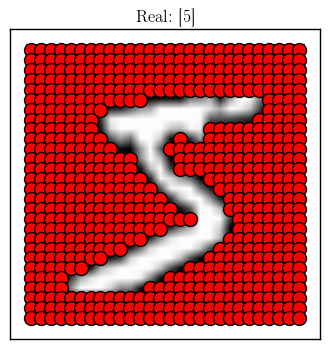

Color: 253 | Count: 54


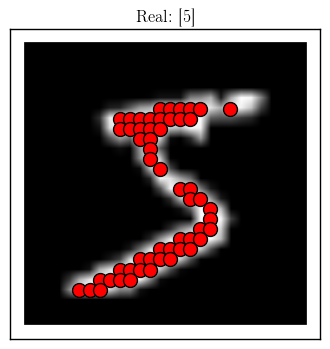

In [5]:
hist = Ims[0].calc_hist(present=True)
for h in hist[:2]:
    print 'Color: %-3d | Count: %-d'%tuple(h)
    Ims[0].show_colors(colors=h, figsize=(4, 4))

<h5 style='color: green; text-align:center;'>
    Бинаризация изображений
</h5>
<ul>
    <li>
        На основе анализа гистограммы, наиболее представленный на изображении цвет считаем фоновым
    </li>
    <li>
        Все остальные цвета считаем соответствующими тексту
    </li>
    <li>
        Бинаризация: переводим цвет фона в нуль, а цвет текста в единицу (функция binarization)
    </li>
    <li>
        Отрисовка нескольких преобразованных изображений для примера
    </li>
</ul>

Total time   (sec.):  123.5
Time per img (sec.):    0.0018


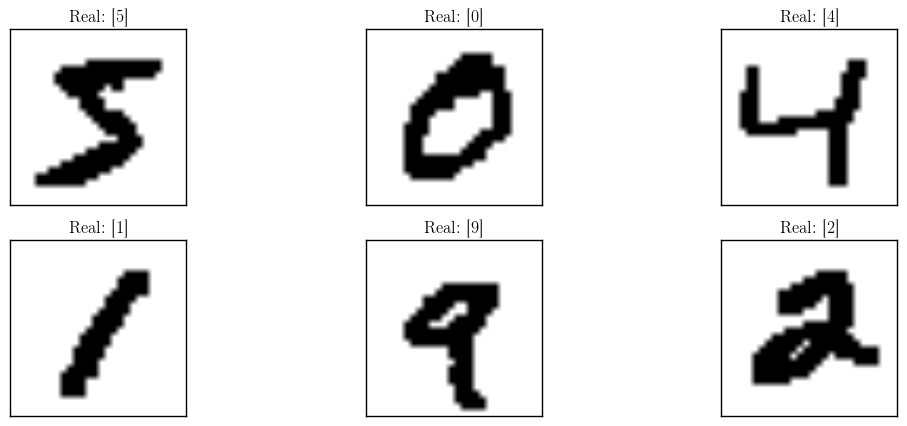

In [6]:
_t = time.time()
for Im in Ims:
    Im.binarization(colors_bg=[0])
print 'Total time   (sec.): %6.1f'%(time.time() - _t)
print 'Time per img (sec.): %9.4f'%((time.time() - _t)/Ims.len_)
Ims.show(n=6, r=2, figsize=(13, 5), figsize_sub=(4, 4))

<h5 style='color: green; text-align:center;'>
    Подготовка данных для обучения сети
</h5>
<ul>
    <li>
        Инициализация класса, представляющего данные
    </li>
    <li>
        Преобразование подготовленных изображений в матрицу входных и выходных векторов
    </li>
    <li>
        Разделение изображений на набор обучающих данных (50000), валидационных данных (0) и тестовых данных (20000)
    </li>
</ul>

In [7]:
_t = time.time()
X_all = Ims.get_matrix(var='arr')
Y_all = Ims.get_matrix(var='smb_real')
print X_all.shape
print Y_all.shape
N_trn = 50000
X_trn, Y_trn = X_all[:, :N_trn], Y_all[:, :N_trn]
X_tst, Y_tst = X_all[:, N_trn:], Y_all[:, N_trn:]
print 'Total time   (sec.): %6.1f'%(time.time() - _t)
print 'Time per img (sec.): %9.4f'%((time.time() - _t)/Ims.len_)

(784, 70000)
(10, 70000)
Total time   (sec.):    1.9
Time per img (sec.):    0.0000


<h5 style='color: green; text-align:center;'>
    Создание нейронной сети
</h5>
<ul>
    <li>
        Инициализируется экземпляр класса нейронной сети и выставляется опция печати промежуточной информации
    </li>
    <li>
        Создаются три слоя с числами нейронов 784 (входной слой), 30 (внутренний слой), 10 (выходной слой)
    </li>
    <li>
        Гиперпараметр числа элементов в подвыборке выбран равным 10, а гиперпараметр скорости обучения выбран равным 3 (на основе ряда текстых расчетов по выбору оптимального значения гиперпараметров)
    </li>
</ul>

In [8]:
NN = NeuralNetwork(verb=True)
NN.add_layers(LayerFC(None, 784))
NN.add_layers(LayerFC(784 ,  30))
NN.add_layers(LayerFC( 30 ,  10))
NN.set_params(mb_size=10, eta=3.)

<h5 style='color: green; text-align:center;'>
    Обучение нейронной сети
</h5>
<ul>
    <li>
        Выбрано 30 эпох для обучения
    </li>
    <li>
        Выходная информация на каждой эпохе обучения:
    </li>
    <ul>
        <li>
            Номер эпохи
        </li>
        <li>
            Время в секундах, затраченное на эпоху
        </li>
        <li>
            Полное количество итераций обратного распространения в сети (с момента создания сети) 
        </li>
        <li>
            Количество данных в тестовом наборе
        </li>
        <li>
            Качество сети после соотвествующей эпохи обучения на тестовом наборе данных (относительная доля неправильных результатов предсказания)
        </li>
    </ul>
</ul>

In [9]:
NN.learning(X_trn, Y_trn, X_tst, Y_tst, epochs=30)

Epoch #  1: T=    9.71; m=    50000; n_check=    20000; e_check=0.106050
Epoch #  2: T=    7.81; m=   100000; n_check=    20000; e_check=0.090200
Epoch #  3: T=    7.90; m=   150000; n_check=    20000; e_check=0.083650
Epoch #  4: T=    8.70; m=   200000; n_check=    20000; e_check=0.077900
Epoch #  5: T=    6.44; m=   250000; n_check=    20000; e_check=0.074450
Epoch #  6: T=    6.51; m=   300000; n_check=    20000; e_check=0.065950
Epoch #  7: T=    6.76; m=   350000; n_check=    20000; e_check=0.067500
Epoch #  8: T=    7.67; m=   400000; n_check=    20000; e_check=0.066400
Epoch #  9: T=    7.30; m=   450000; n_check=    20000; e_check=0.063100
Epoch # 10: T=    7.39; m=   500000; n_check=    20000; e_check=0.062700
Epoch # 11: T=    6.64; m=   550000; n_check=    20000; e_check=0.065500
Epoch # 12: T=    6.99; m=   600000; n_check=    20000; e_check=0.063800
Epoch # 13: T=    6.80; m=   650000; n_check=    20000; e_check=0.062500
Epoch # 14: T=    8.26; m=   700000; n_check=    20

<i>Комментарий:</i> как следует из результатов, нейронная сеть после 30 эпох обучения дает менее $6\%$ ошибок на тестовой выборке размера 20000 (качество предсказания может быть существенно улучшено путем лучшего выбора гиперпараметров сети).

<h5 style='color: green; text-align:center;'>
    Добавим еще один слой из 30 нейронов к сети и соответствующим образом модифицируем параметр скорости обучения и максимальное число эпох обучения
</h5>

In [20]:
NN = NeuralNetwork(verb=True)
NN.add_layers(LayerFC(None, 784))
NN.add_layers(LayerFC(784 ,  30))
NN.add_layers(LayerFC( 30 ,  30))
NN.add_layers(LayerFC( 30 ,  10))
NN.set_params(mb_size=10, eta=1.5)
NN.learning(X_trn, Y_trn, X_tst, Y_tst, epochs=50)

Epoch #  1: T=    9.30; m=    50000; n_check=    20000; e_check=0.122550
Epoch #  2: T=   12.27; m=   100000; n_check=    20000; e_check=0.096000
Epoch #  3: T=    8.18; m=   150000; n_check=    20000; e_check=0.091200
Epoch #  4: T=    7.97; m=   200000; n_check=    20000; e_check=0.079100
Epoch #  5: T=    7.66; m=   250000; n_check=    20000; e_check=0.076500
Epoch #  6: T=   10.33; m=   300000; n_check=    20000; e_check=0.072750
Epoch #  7: T=    8.65; m=   350000; n_check=    20000; e_check=0.072650
Epoch #  8: T=    7.59; m=   400000; n_check=    20000; e_check=0.071700
Epoch #  9: T=   10.79; m=   450000; n_check=    20000; e_check=0.071350
Epoch # 10: T=    7.56; m=   500000; n_check=    20000; e_check=0.066400
Epoch # 11: T=    7.86; m=   550000; n_check=    20000; e_check=0.067650
Epoch # 12: T=    7.54; m=   600000; n_check=    20000; e_check=0.064750
Epoch # 13: T=    7.54; m=   650000; n_check=    20000; e_check=0.061650
Epoch # 14: T=    7.74; m=   700000; n_check=    20

<i>Комментарий:</i> как видим, точность существенно не увеличилась.

<h5 style='color: green; text-align:center;'>
    Проверка качества предсказания на конкретном примере
</h5>
<ul>
    <li>
        Выбираем одно изображение (последнее изображение из набора) для примера и получаем соответствующие интенсивности пикселей (x)
    </li>
    <li>
        Запускаем расчет посредством обученной нейронной сети и выводим результат (предсказание сети)
    </li>
    <li>
        Отрисовываем изображение
    </li>
</ul>

The answer of the neural network is  6


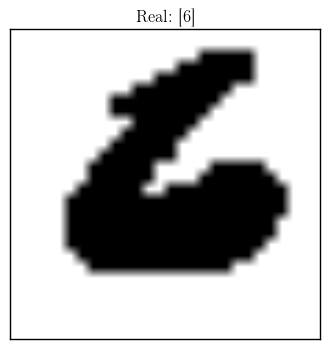

In [13]:
Im = Ims[-1]
x = Im.get_vector('arr')
a = NN.forward(x)
print 'The answer of the neural network is ', np.argmax(a)
Im.show(figsize=(4, 4))

<i>Комментарий:</i> обученная нейронная сеть выдала правильное предсказание (цифра 6).

<h5 style='color: green; text-align:center;'>
    Сохраняем обученную нейронную сеть в файл для возможности последующего использования
</h5>

In [14]:
NN.save('./nn_saved/nn_mnist.p')

<h5 style='color: green; text-align:center;'>
    Загружаем (для проверки корректности опции сохранения) обученную нейронную сеть из файла и демонстрируем первый ошибочный результат распознавания
</h5>

NN result is "3" (real value is "9"). Image number is 49


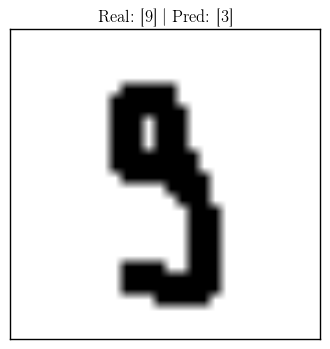

In [21]:
NN = nn_load('./nn_saved/nn_mnist.p')

for i, Im in enumerate(Ims):
    x = Im.get_vector('arr')
    a = NN.forward(x)
    a = np.argmax(a)
    Im.smb_calc = unicode(a)
    if not Im.symb_is_corr:
        print 'NN result is "%s" (real value is "%s"). Image number is %d'%(Im.smb_calc, Im.smb_real, i+1)
        break
Im.show(figsize=(4, 4))

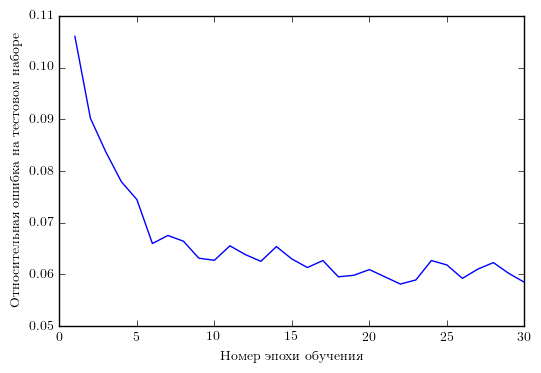

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

NN = nn_load('./nn_saved/nn_mnist.p')
eps = range(1, len(NN.e)+1)
plt.xlabel(u'Номер эпохи обучения')
plt.ylabel(u'Относительная ошибка на тестовом наборе')
plt.plot(eps, NN.e)
plt.show()